<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pixel-CMDs" data-toc-modified-id="Pixel-CMDs-1">Pixel-CMDs</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2">Background</a></span><ul class="toc-item"><li><span><a href="#Integrated-Stellar-Populations" data-toc-modified-id="Integrated-Stellar-Populations-2.1">Integrated Stellar Populations</a></span></li><li><span><a href="#Integrated-Stellar-Populations" data-toc-modified-id="Integrated-Stellar-Populations-2.2">Integrated Stellar Populations</a></span></li><li><span><a href="#Resolved-Stellar-Populations" data-toc-modified-id="Resolved-Stellar-Populations-2.3">Resolved Stellar Populations</a></span></li><li><span><a href="#Resolved-Stellar-Populations" data-toc-modified-id="Resolved-Stellar-Populations-2.4">Resolved Stellar Populations</a></span></li><li><span><a href="#Resolved-Stellar-Populations" data-toc-modified-id="Resolved-Stellar-Populations-2.5">Resolved Stellar Populations</a></span></li><li><span><a href="#Semi-Resolved-Stellar-Populations" data-toc-modified-id="Semi-Resolved-Stellar-Populations-2.6">Semi-Resolved Stellar Populations</a></span></li></ul></li><li><span><a href="#The-Basic-Model" data-toc-modified-id="The-Basic-Model-3">The Basic Model</a></span></li><li><span><a href="#Model-parameters" data-toc-modified-id="Model-parameters-4">Model parameters</a></span><ul class="toc-item"><li><span><a href="#Npix:-integrated-stellar-mass" data-toc-modified-id="Npix:-integrated-stellar-mass-4.1">Npix: integrated stellar mass</a></span></li><li><span><a href="#[Fe/H]:-Metal-Abundance" data-toc-modified-id="[Fe/H]:-Metal-Abundance-4.2">[Fe/H]: Metal Abundance</a></span></li><li><span><a href="#E(B-V):-Dust-Extinction" data-toc-modified-id="E(B-V):-Dust-Extinction-4.3">E(B-V): Dust Extinction</a></span></li><li><span><a href="#Star-Formation-History" data-toc-modified-id="Star-Formation-History-4.4">Star-Formation History</a></span></li></ul></li><li><span><a href="#Fit-Using-Nested-Sampling-(Dynesty)" data-toc-modified-id="Fit-Using-Nested-Sampling-(Dynesty)-5">Fit Using Nested Sampling (Dynesty)</a></span></li><li><span><a href="#Complex-Models" data-toc-modified-id="Complex-Models-6">Complex Models</a></span></li></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import pandas as pd
import pcmdpy as ppy
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
# sns.set_context('poster')

In [3]:
try:
    ppy.gpu_utils.initialize_gpu(n=0)
    GPU_AVAIL = True
except:
    GPU_AVAIL = False

Can't initialize GPU, _GPU_AVAIL is set to False


In [4]:
f = ppy.instrument.m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=GPU_AVAIL)

In [5]:
def plot_pcmd(pcmd, bins=100, norm=mpl.colors.LogNorm(), ax=None, title=None, isochrone_kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    g = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 2., 10.]))
    ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=norm, normed=True)
    iso_model.plot_isochrone(g, axes=ax, zorder=-1, **isochrone_kwargs)
    if title is not None:
        ax.set_title(title)
    return ax

In [6]:
def plot_model(model, N_im=256, **plot_kwargs):
    pcmd, _ = driv.simulate(model, N_im)
    return plot_pcmd(pcmd, **plot_kwargs)

# Pixel-CMDs

Ben Cook

Conroy Group Meeting 

21 March 2018

# Background

Observing a galaxy (photometry, spectra maybe, etc.)

Our goal is generically to measure its:

* Stellar Mass
* Metal Abundances
* Star Formation History
* Dust Content
* ...

A galaxy's light is (primarily) contributed by the stars it contains.

So, we combine our knowledge of stars and their evolution into understanding galaxies.

** Stellar Population Synthesis **

## Integrated Stellar Populations 
or: SED Modelling

<img src="phot_agn_only.jpg" width=800 />  **Leja et al. 2018**

## Integrated Stellar Populations 

* Can assume fully-populated isochrones
* Typically need wide spectral coverage
* Uncertanties come from rare, highly-evolved phases of stellar evolution (+AGN, dust, ...)

## Resolved Stellar Populations
or: CMD modelling
** M13 (as seen by HST)**
<img src="M13.jpg" width=600/>

## Resolved Stellar Populations
<img src="cmd.gif" width=600/>

## Resolved Stellar Populations

* Observe individual stars, and compare to isochrone models
* Often only need 2 colors to measure metallicity, SFH
* Limited by spatial resolution (crowding) and exposure (faintness limit)

## Semi-Resolved Stellar Populations
or: Pixel-CMDs

We're studying the intermediate regime, where:
* Can't resolve individual stars (crowding limited)
* Can't assume isochrones are fully populated (surface-brightness fluctuations)

It makes sense to describe systems by $N_{pix}$: the typical number of stars per pixel

* Resolved CMDs: $N_{pix} \ll 1$
* Semi-Resolved Stellar Populations: $N_{pix} \sim 1 \rightarrow 10^{7}$
* Integrated Stellar Populations: $N_{pix} \gg 10^7$

Due to Poisson fluctuations, some pixels will have fewer bright-rare stars than others.

* Surface-brightness fluctuations contain information!

**M31 Bulge (PHAT survey)**
<img src="M31-PHAT-Mosaic-A-2.jpg" width=600/>

What is the distribution of colors and magnitudes on a pixel-by-pixel basis?

**Pixel Color-Magnitude Diagrams**

In [7]:
pcmd_m31_b = np.loadtxt('../../data/m31_bulge_M2.dat', unpack=True)[::-1]
pcmd_m31_d = np.loadtxt('../../data/m31_b06-263.dat', unpack=True)[::-1]
norm = mpl.colors.LogNorm()

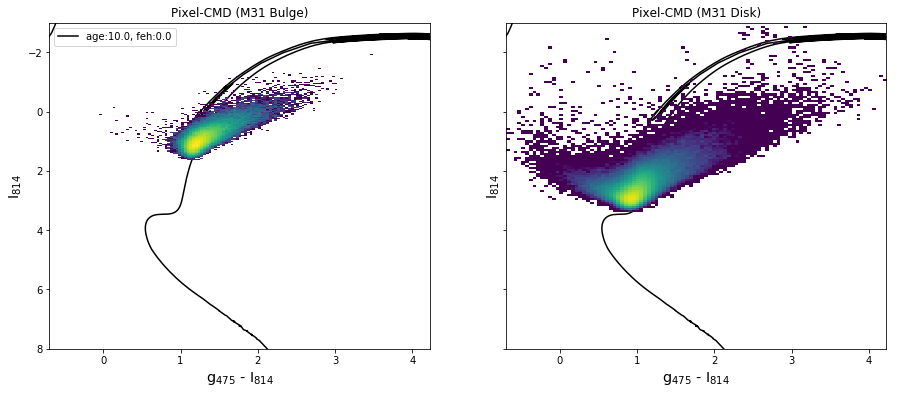

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharex=True, sharey=True)
_ = plot_pcmd(pcmd_m31_b, title='Pixel-CMD (M31 Bulge)', norm=norm, ax=axes[0], isochrone_kwargs={'system':'ab'})
_ = plot_pcmd(pcmd_m31_d, title='Pixel-CMD (M31 Disk)', norm=norm, ax=axes[1], isochrone_kwargs={'system':'ab'})
axes[0].set_ylim([8, -3.])
axes[0].legend(loc=0)

# The Basic Model

For a given population of stars (metallicity, Star-formation History, IMF), 

want to create a forward-model of the image and pixel-CMD

* use isochrones (magnitude, color, mass) from MIST

* assume each pixel in the image contains roughly $N_{pix}$ stars

* randomly populate the pixels with stars from the isochrones

* apply observational effects (dust extinction, HST PSF, ...)

* compare resulting pixel-CMD to observed data

In [9]:
m31_model = ppy.galaxy.DefaultTau.get_model(np.array([0.2, -2., 2.3, 2.5]), iso_step=-1)
N_im = 128
if GPU_AVAIL:
    N_im = 1024
    m31_model = ppy.galaxy.DefaultTau.get_model(np.array([0.2, -2., 2.3, 2.5]))
pcmd_model_b, _ = driv.simulate(m31_model, N_im, system='ab')

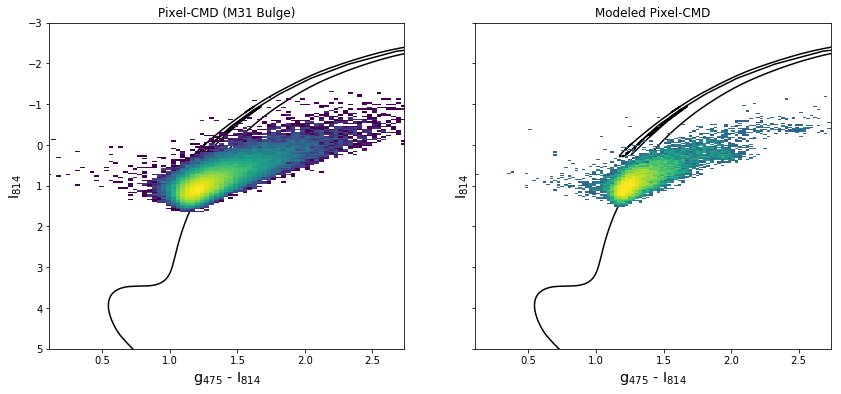

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True, sharex=True)
plot_pcmd(pcmd_m31_b, title='Pixel-CMD (M31 Bulge)', ax=axes[0], isochrone_kwargs={'system':'ab'})
plot_pcmd(pcmd_model_b, title='Modeled Pixel-CMD', ax=axes[1], isochrone_kwargs={'system':'ab'})
axes[0].set_ylim([5., -3.]);

In [11]:
m31_d_model = ppy.galaxy.DefaultTau.get_model(np.array([-0.1, -2., 1.5, 5.]), iso_step=-1)
N_im = 128
if GPU_AVAIL:
    N_im = 1024
    m31_d_model = ppy.galaxy.DefaultTau.get_model(np.array([-0.1, -2., 1.5, 5.]))
pcmd_model_d, _ = driv.simulate(m31_d_model, N_im, system='ab')

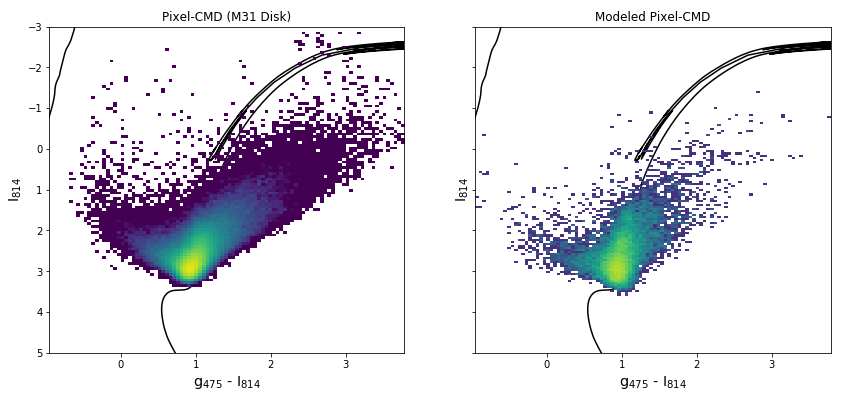

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True, sharex=True)
plot_pcmd(pcmd_m31_d, title='Pixel-CMD (M31 Disk)', ax=axes[0], isochrone_kwargs={'system':'ab'})
plot_pcmd(pcmd_model_d, title='Modeled Pixel-CMD', ax=axes[1], isochrone_kwargs={'system':'ab'})
axes[0].set_ylim([5., -3.]);

# Model parameters

## Npix: integrated stellar mass
* increases magnitude
* narrows pCMD distribution

In [13]:
N_im = 128
if GPU_AVAIL:
    N_im = 1025

In [14]:
g1 = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 2., 10.]))
g2 = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 3., 10.]))
g3 = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 4., 10.]))

pcmd1_n, im1_n = driv.simulate(g1, N_im)
pcmd2_n, im2_n = driv.simulate(g2, N_im)
pcmd3_n, im3_n = driv.simulate(g3, N_im)

((5.0, -5.0), (0.5, 3), None)

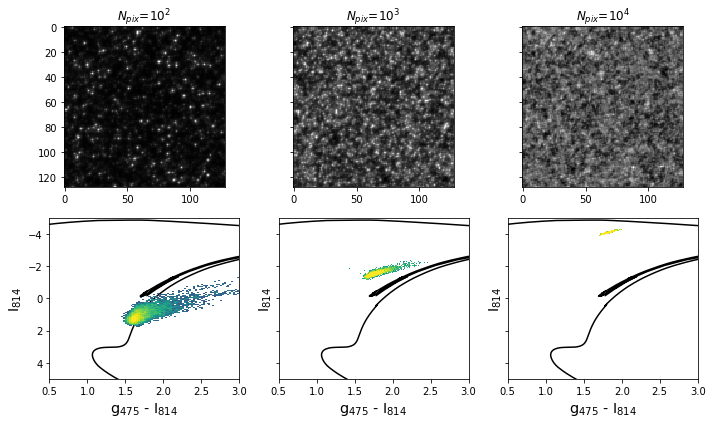

In [15]:
fig, a = plt.subplots(ncols=3, nrows=2, figsize=(10, 6), sharex='row', sharey='row')
a[0,0].imshow(im1_n[0],cmap='Greys_r'),a[0,0].set_title(r'$N_{pix}$=10$^2$')
a[0,1].imshow(im2_n[0],cmap='Greys_r'),a[0,1].set_title(r'$N_{pix}$=10$^3$')
a[0,2].imshow(im3_n[0],cmap='Greys_r'),a[0,2].set_title(r'$N_{pix}$=10$^4$')
plot_pcmd(pcmd1_n,ax=a[1,0]), plot_pcmd(pcmd2_n,ax=a[1,1]), plot_pcmd(pcmd3_n,ax=a[1,2])
a[1,0].set_ylim([5., -5.]),a[1,0].set_xlim([0.5, 3]),plt.tight_layout()

## [Fe/H]: Metal Abundance
* Shifts pCMD towards red
* Also alters shape of pCMD distribution

In [37]:
g1 = ppy.galaxy.DefaultSSP.get_model(np.array([-1., -2., 2., 10.]))
g2 = ppy.galaxy.DefaultSSP.get_model(np.array([-0.5, -2., 2., 10.]))
g3 = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 2., 10.]))

pcmd1_f, im1_f = driv.simulate(g1, N_im)
pcmd2_f, im2_f = driv.simulate(g2, N_im)
pcmd3_f, im3_f = driv.simulate(g3, N_im)

((5.0, -10.0), (0.5, 3), None)

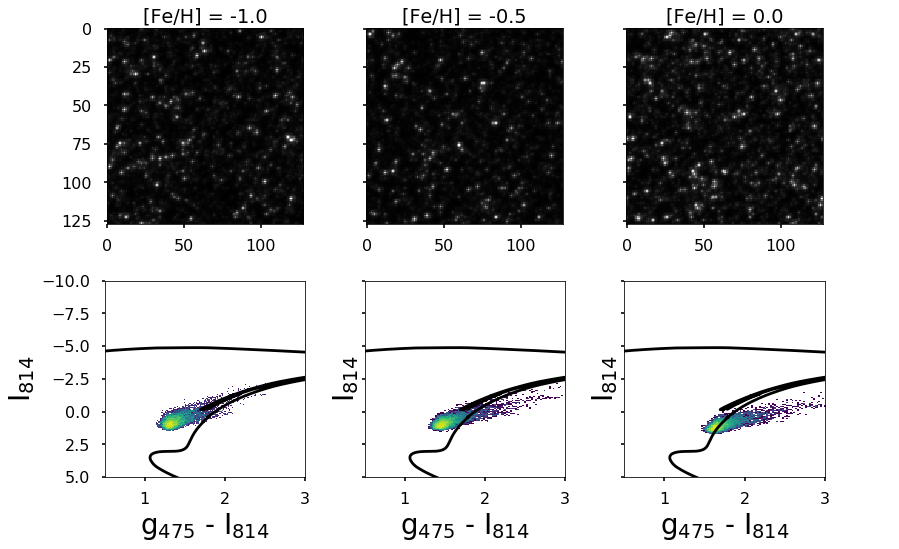

In [38]:
fig, a = plt.subplots(ncols=3, nrows=2, figsize=(10, 6), sharex='row', sharey='row')
a[0,0].imshow(im1_f[0],cmap='Greys_r'),a[0,0].set_title(r'[Fe/H] = -1.0')
a[0,1].imshow(im2_f[0],cmap='Greys_r'),a[0,1].set_title(r'[Fe/H] = -0.5')
a[0,2].imshow(im3_f[0],cmap='Greys_r'),a[0,2].set_title(r'[Fe/H] = 0.0')
plot_pcmd(pcmd1_f,ax=a[1,0]),plot_pcmd(pcmd2_f,ax=a[1,1]),plot_pcmd(pcmd3_f,ax=a[1,2])
a[1,0].set_ylim([5., -10.]),a[1,0].set_xlim([0.5, 3]),plt.tight_layout()

## E(B-V): Dust Extinction
* Shifts pCMD towards red

In [41]:
g1 = ppy.galaxy.DefaultSSP.get_model(np.array([0., -1., 2., 10.]))
g2 = ppy.galaxy.DefaultSSP.get_model(np.array([0., -0.5, 2., 10.]))
g3 = ppy.galaxy.DefaultSSP.get_model(np.array([0., 0., 2., 10.]))

pcmd1_d, im1_d = driv.simulate(g1, N_im)
pcmd2_d, im2_d = driv.simulate(g2, N_im)
pcmd3_d, im3_d = driv.simulate(g3, N_im)

NameError: name 'im1_d' is not defined

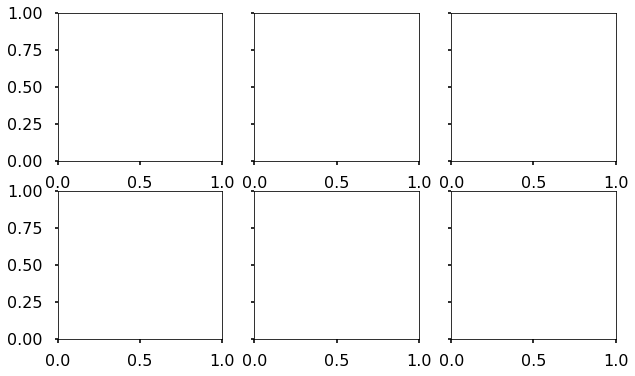

In [24]:
fig, a = plt.subplots(ncols=3, nrows=2, figsize=(10, 6), sharex='row', sharey='row')
a[0,0].imshow(im1_d[0], cmap='Greys_r'),a[0,0].set_title(r'E(B-V) = 0.1')
a[0,1].imshow(im2_d[0], cmap='Greys_r'),a[0,1].set_title(r'E(B-V) = 0.3')
a[0,2].imshow(im3_d[0], cmap='Greys_r'),a[0,2].set_title(r'E(B-V) = 1.0')
plot_pcmd(pcmd1_d, ax=a[1,0]), plot_pcmd(pcmd2_d, ax=a[1,1]), plot_pcmd(pcmd3_d, ax=a[1,2])
a[1,0].set_ylim([5., -10.]),a[1,0].set_xlim([0.5, 5]),plt.tight_layout()

## Star-Formation History
* Simplest model: SSP
  * $N_{pix}$ and age
* $\tau$ model: $SFR \sim \exp(-t / \tau)$
  * $N_{pix}$ and $\tau$
* Non-Parametric model:
  * Fit for $N_{pix}$ in each age bin

In [8]:
g1 = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 2., 10.]), iso_step=-1)
g2 = ppy.galaxy.DefaultTau.get_model(np.array([0., -2, 2., 2.]), iso_step=-1)
g3 = ppy.galaxy.DefaultTau.get_model(np.array([0., -2., 2., 10.]), iso_step=-1)

pcmd1_s, im1_s = driv.simulate(g1, N_im)
pcmd2_s, im2_s = driv.simulate(g2, N_im)
pcmd3_s, im3_s = driv.simulate(g3, N_im)

((3.0, -2.0), (0.5, 3), None)

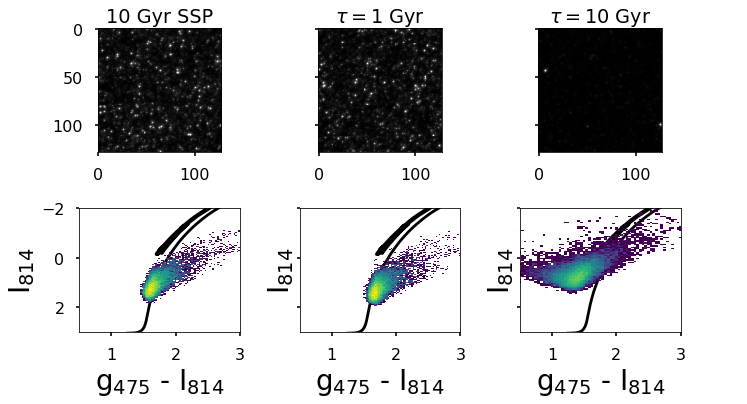

In [35]:
fig, a = plt.subplots(ncols=3, nrows=2, figsize=(10, 6), sharex='row', sharey='row')
a[0,0].imshow(im1_s[0],cmap='Greys_r'),a[0,0].set_title(r'10 Gyr SSP')
a[0,1].imshow(im2_s[0],cmap='Greys_r'),a[0,1].set_title(r'$\tau = 2$ Gyr')
a[0,2].imshow(im3_s[0],cmap='Greys_r'),a[0,2].set_title(r'$\tau = 10$ Gyr')
plot_pcmd(pcmd1_s, ax=a[1,0]),plot_pcmd(pcmd2_s,ax=a[1,1]),plot_pcmd(pcmd3_s,ax=a[1,2])
a[1,0].set_ylim([3., -2.]),a[1,0].set_xlim([0.5, 3]), plt.tight_layout()

# Fit Using Nested Sampling (Dynesty)

In [16]:
res = {}
t = ppy.galaxy.DefaultTau.get_model([-0.2, -2., 2., 5.])
p = ppy.galaxy.DefaultTau.get_flat_prior([[-1.5, 0.5]], [[-2.5, -0.5]], [[1., 4.], [1., 9.]])
res['base'] = ppy.utils.ResultsPlotter('../../scripts_py/results/mock_tau_nlive.csv',true_model=t, prior=p, run_name='Mock Tau')

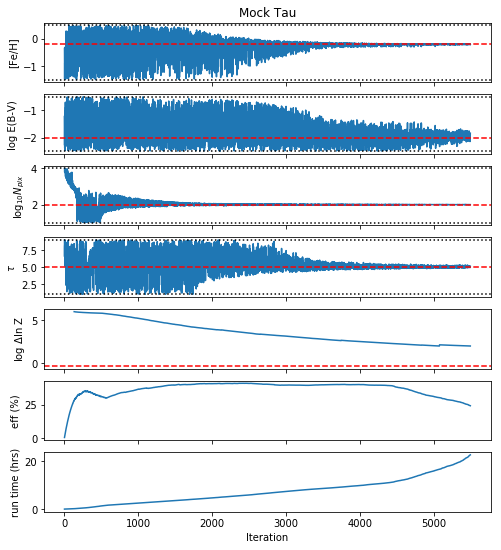

In [32]:
res['base'].plot_chains();

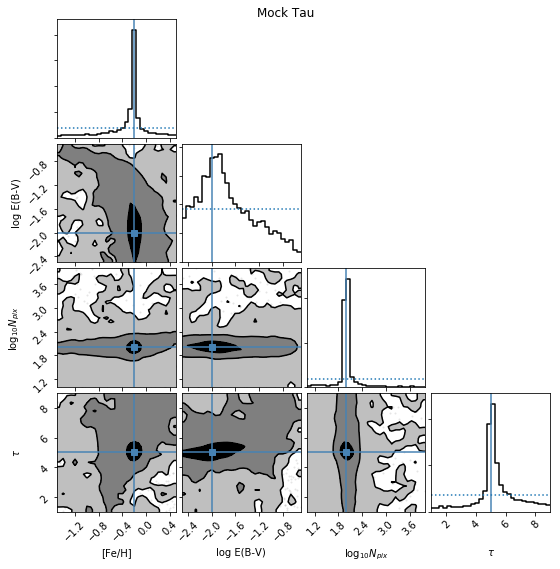

In [33]:
f, a = plt.subplots(ncols=4, nrows=4, figsize=(8,8)); res['base'].plot_corner(f, weight=False);

# Complex Models